In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
!pip install torch torchvision tensorboard

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import matplotlib.pyplot as plt

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_features):
    super().__init__()
    self.disc = nn.Sequential(
      nn.Linear(in_features, 128),
      nn.LeakyReLU(0.01),
      nn.Linear(128, 1),
      nn.Sigmoid(),
    )

  def forward(self, x):
    return self.disc(x)

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim, img_dim):
    super().__init__()
    self.gen = nn.Sequential(
      nn.Linear(z_dim, 256),
      nn.LeakyReLU(0.01),
      nn.Linear(256, img_dim),
      nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
    )

  def forward(self, x):
    return self.gen(x)

In [ ]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 50

In [ ]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

In [ ]:
len(dataset)
#len(loader)

60000

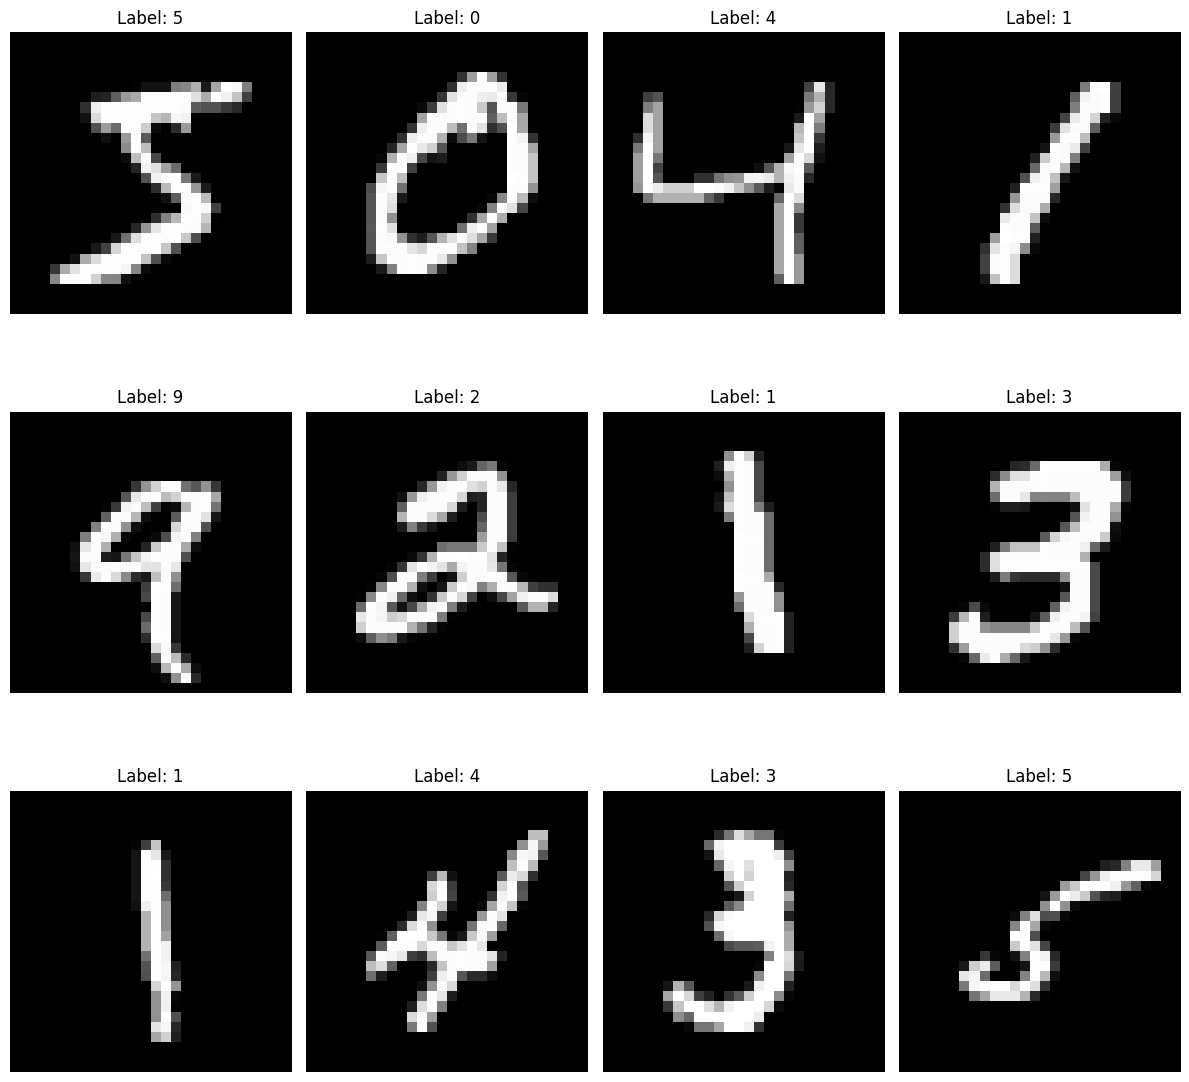

In [ ]:
# Define the grid dimensions
rows, cols = 3, 4

# Create a figure
fig, axs = plt.subplots(rows, cols, figsize=(12, 12))

# Loop to plot images
for i in range(rows * cols):
    image, label = dataset[i]  # Access the sample
    ax = axs[i // cols, i % cols]  # Calculate subplot position
    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
losses = []
dis_decs = []
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        if batch_idx == 0:
          losses.append((lossD.item(), lossG.item()))  # Append Discriminator and Generator losses
          dis_decs.append((disc_real.mean().item(), disc_fake.mean().item()))  # Append discriminator outputs
          print(
              f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                    Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
          )

Epoch [0/50] Batch 0/1875                       Loss D: 0.5269, loss G: 1.2747
Epoch [1/50] Batch 0/1875                       Loss D: 0.6459, loss G: 0.9530
Epoch [2/50] Batch 0/1875                       Loss D: 0.5560, loss G: 1.0965
Epoch [3/50] Batch 0/1875                       Loss D: 0.3668, loss G: 1.7096
Epoch [4/50] Batch 0/1875                       Loss D: 0.5918, loss G: 1.4056
Epoch [5/50] Batch 0/1875                       Loss D: 0.6547, loss G: 0.9112
Epoch [6/50] Batch 0/1875                       Loss D: 0.5427, loss G: 1.2427
Epoch [7/50] Batch 0/1875                       Loss D: 0.3317, loss G: 1.7860
Epoch [8/50] Batch 0/1875                       Loss D: 0.4700, loss G: 1.6767
Epoch [9/50] Batch 0/1875                       Loss D: 0.4155, loss G: 1.6232
Epoch [10/50] Batch 0/1875                       Loss D: 0.4633, loss G: 1.6885
Epoch [11/50] Batch 0/1875                       Loss D: 0.7509, loss G: 1.4264
Epoch [12/50] Batch 0/1875                       L

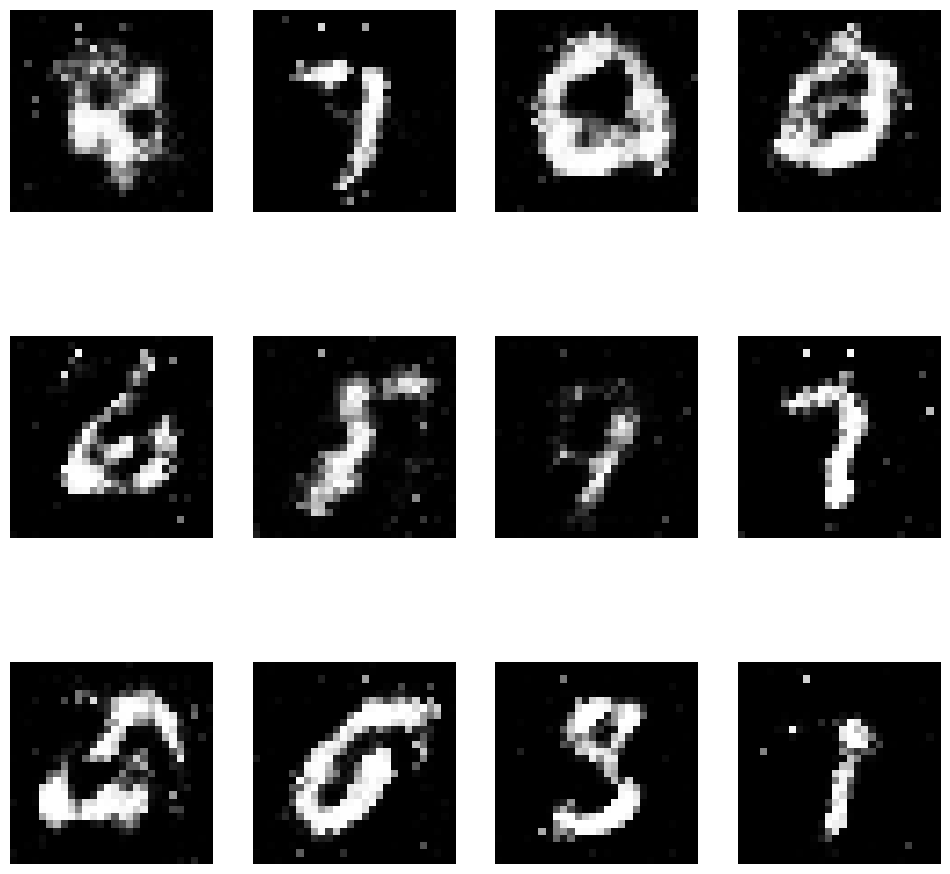

In [ ]:
import matplotlib.pyplot as plt
gen.eval()
fake_data = gen(torch.randn(12,z_dim).to(device)).cpu()

fig, axs = plt.subplots(3, 4, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i].detach().squeeze().view(28, 28), cmap="gray")
    ax.axis('off')
plt.show()


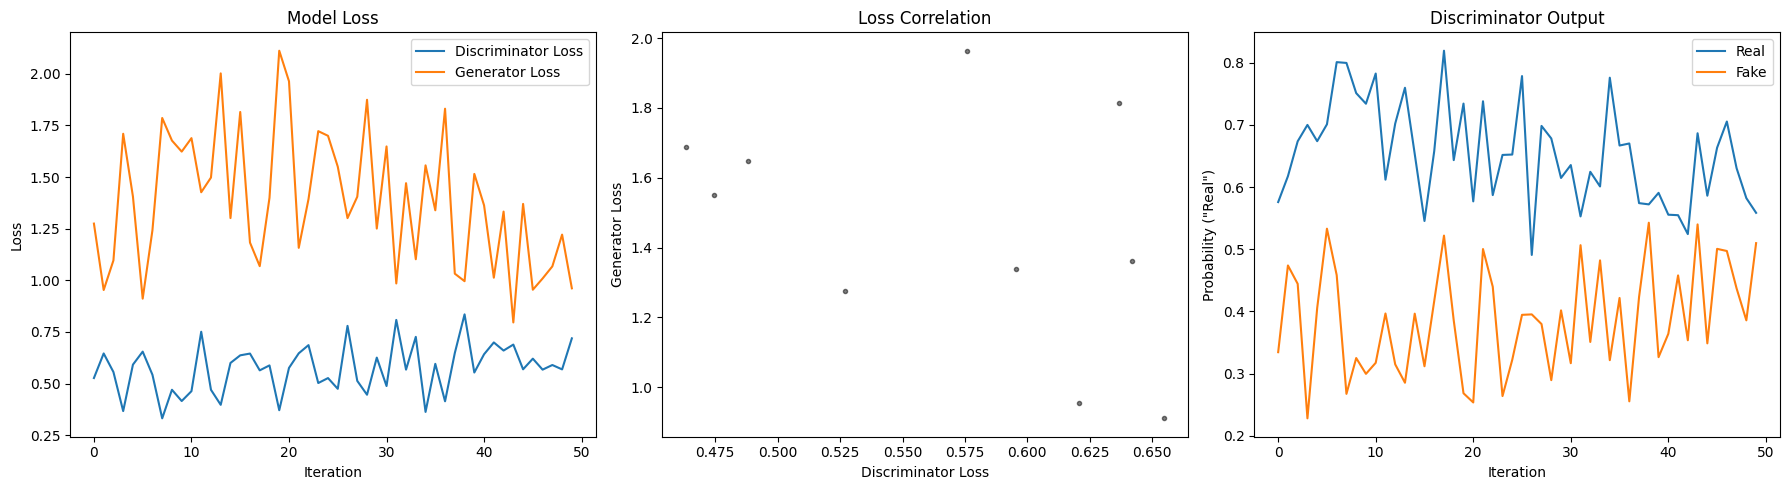

In [ ]:
import numpy as np
losses = np.array(losses)
dis_decs = np.array(dis_decs)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Loss Plot
ax[0].plot(losses[:, 0], label='Discriminator Loss')
ax[0].plot(losses[:, 1], label='Generator Loss')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend()

# Discriminator Output Probability
ax[2].plot(dis_decs[:, 0], label='Real')
ax[2].plot(dis_decs[:, 1], label='Fake')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Probability ("Real")')
ax[2].set_title('Discriminator Output')
ax[2].legend()

plt.tight_layout()
plt.show()

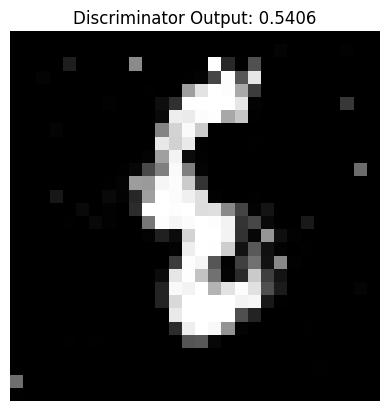

Discriminator's output for the fake image: 0.5406038761138916


In [ ]:
import matplotlib.pyplot as plt

# Step 1: Generate a fake image
noise = torch.randn(1, z_dim).to(device)  # Latent vector for a single fake image
fake_image = gen(noise)  # Generate the fake image

# Step 2: Pass the fake image through the discriminator
discriminator_output = disc(fake_image)

# Step 3: Visualize the generated fake image
fake_image = fake_image.view(28, 28).cpu().detach().numpy()  # Reshape and move the image to CPU

# Plot the fake image
plt.imshow(fake_image, cmap='gray')
plt.title(f'Discriminator Output: {discriminator_output.item():.4f}')
plt.axis('off')
plt.show()

# Step 4: Print the discriminator's output
print(f"Discriminator's output for the fake image: {discriminator_output.item()}")